# Indoor Positioning

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import models
from keras import layers
import json
import random
import numpy as np
from matplotlib import pyplot as plt

## Load Data

Copy local_records.json file to the same directory as this script, and then run:

In [5]:
# load local_records.json data
with open('new.json', 'r') as file:
    data = file.read()
json_list = json.loads(data)

The data is split into 80% training data, 20% testing data

In [6]:
# shuffle the list
random.shuffle(json_list)
# split into train data and test data
ratio_of_train_data = 0.8
cut_i = int(ratio_of_train_data * len(json_list))
train = json_list[:cut_i]
test = json_list[cut_i:]

In [7]:
print(len(train))
print(len(test))

32431
8108


## Extract features and lables

feature: [RSSI of AP_1_2GHZ, RSSI of AP_1_5GHZ, RSSI of AP_2_2GHZ, RSSI of AP_2_5GHZ, RSSI of AP_3_2GHZ, RSSI of AP_3_5GHZ, RSSI of AP_4_2GHZ, RSSI of AP_4_5GHZ]

label: [x , y]

In [8]:
# extract features and lables from data
index_map = {'SCSLAB_AP_1_2GHZ': 1, 'SCSLAB_AP_1_5GHZ': 2, 'SCSLAB_AP_2_2GHZ': 3,\
            'SCSLAB_AP_2_5GHZ': 4, 'SCSLAB_AP_3_2GHZ': 5, 'SCSLAB_AP_3_5GHZ': 6,\
            'SCSLAB_AP_4_2GHZ': 7, 'SCSLAB_AP_4_5GHZ': 8}

def extract_feature_and_label(l):
    feature_list = []
    lable_list = []
    for json_obj in l:
        # extract lable
        x = json_obj.get('ref_x')
        y = json_obj.get('ref_y')
        lable_list.append([x, y])
        # extract feature
        #feature = [0 for i in range(9)]
        feature = [0 for i in range(8)]
        #angle = json_obj.get('angle')
        #feature[0] = angle
        rssi_observations = json_obj.get('rssi_observations')
        for observation in rssi_observations:
            ssid = observation.get('SSID')
            index = index_map[ssid]
            feature[index-1] = observation.get('RSSI')
        feature_list.append(feature)
    return np.array(feature_list, dtype='float64'), np.array(lable_list, dtype='float64')

train_data, train_labels = extract_feature_and_label(train)
test_data, test_labels = extract_feature_and_label(test)

## Normalize data

In [9]:
max_rss = train_data.max(axis=0)
min_rss = train_data.min(axis=0)

train_data = (train_data - min_rss)/(max_rss - min_rss)
test_data = (test_data - min_rss)/(max_rss - min_rss)

In [10]:
max_rss

array([-34., -47., -29., -44., -28., -43., -13., -33.])

In [11]:
min_rss

array([-91., -97., -94., -97., -85., -96., -79., -96.])

In [26]:
train_data

array([[0.75438596, 0.9       , 0.78461538, ..., 0.47169811, 0.59090909,
        0.71428571],
       [0.80701754, 0.4       , 0.6       , ..., 0.49056604, 0.59090909,
        0.61904762],
       [0.75438596, 0.58      , 0.73846154, ..., 0.56603774, 0.54545455,
        0.68253968],
       ...,
       [0.66666667, 0.68      , 0.78461538, ..., 0.58490566, 0.48484848,
        0.61904762],
       [0.75438596, 0.54      , 0.78461538, ..., 0.39622642, 0.57575758,
        0.65079365],
       [0.56140351, 0.52      , 0.67692308, ..., 0.33962264, 0.54545455,
        0.73015873]])

## Build model

Define Loss Function - Euclidean distance

In [13]:
def euclidean_distance(y_true, y_pred):
    return tf.norm(y_true - y_pred, ord='euclidean')

Define Model

In [21]:
model = models.Sequential()
model.add(layers.Dense(256, activation='relu',input_shape=(train_data.shape[1],)))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.compile(optimizer='adam', loss=euclidean_distance, metrics=['mse'])

In [22]:
history = model.fit(train_data, train_labels, epochs=50, batch_size=20, verbose=0, validation_split=0.2)
loss, mse = model.evaluate(test_data, test_labels)

254/254 [==============================] - 0s 1ms/step - loss: 5.8104 - mse: 0.5737


In [14]:
loss

0.6204293966293335

In [15]:
mse

0.4728020131587982

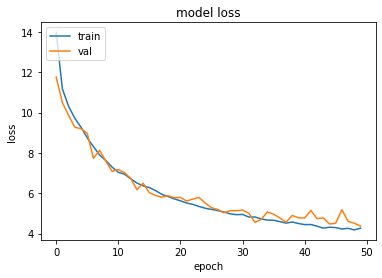

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Download model

In [24]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\ASUS\AppData\Local\Temp\tmpfjb6i21s\assets


In [25]:
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)